In [2]:
import torch
import os
import re
import sys
import cv2
from config_reader import config_reader
import util
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter

In [3]:
from PoseEstimator import PoseEstimation

In [4]:
torch_device = torch.device('cuda:3')

## Dataloader

In [5]:
def prepare_image(img_path):
    param_, model_ = config_reader()
    oriImg = cv2.imread(img_path) # B,G,R order
    imageToTest = torch.FloatTensor(oriImg).permute((2,0,1))[None]
    multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

    heatmap_avg = torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])).to(torch_device)
    paf_avg = torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])).to(torch_device)

    scale = 1
    h = int(oriImg.shape[0]*scale)
    w = int(oriImg.shape[1]*scale)
    pad_h = 0 if (h%model_['stride']==0) else model_['stride'] - (h % model_['stride']) 
    pad_w = 0 if (w%model_['stride']==0) else model_['stride'] - (w % model_['stride'])
    new_h = h + pad_h
    new_w = w + pad_w

    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
    imageToTest_padded = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5
    
    feed = torch.Tensor(imageToTest_padded)

    return feed

In [6]:
class CocoHuman(torch.utils.data.Dataset):
    def __init__(self, PATH, transform=None, mode='full', specify_index=None):
  
        self.PATH = PATH
        self.ids = []
        self.transform = transform
        self.Images = []
        self.Masks = []
        
        # load indexes
        if specify_index is None:
            specify_index = range(len(list(os.walk(self.PATH + '/images/'))[0][2]))
          
        for j, id_ in  enumerate(list(os.walk(self.PATH + '/images/'))[0][2]):
            if j in specify_index:
                self.ids.append(id_)
                
        self.len = len(self.ids)
         
        # load images and masks
        for id_ in tqdm(self.ids):
            Image = prepare_image(self.PATH + '/images/' + id_)
            self.Images.append(Image)
            
            Mask = (imread(self.PATH + '/masks/m_' + id_)[:,:,0] > 128).astype(np.uint8)
            Mask = torch.LongTensor(Mask)
            self.Masks.append(Mask)
            
            
    def __len__(self):
        return self.len
    
    
    def __getitem__(self, idx):      
        sample = {}
        sample['image'] = self.Images[idx]
        sample['mask'] = self.Masks[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample        

In [7]:
test_index = [1000, 1002, 1005, 1008, 1010, 1015, 1017, 1020, 
              1024, 1025, 1028, 1030, 1032, 1035, 1044, 1045, 
              1046, 1033, 1054, 1056, 1058, 1060, 1062, 1064, 
              1065, 1067, 1070, 1071, 1075, 1076, 1082, 1085, 
              1087, 1089]        # nice pictures with people
test_dataset = CocoHuman('./dataset/1/', transform=None, specify_index=test_index)

100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


In [8]:
train_dataset = CocoHuman('./dataset/3/', transform=None, specify_index=range(2500, 5000))

100%|██████████| 2500/2500 [08:04<00:00,  5.16it/s]


## Transfer learning

In [9]:
# load trained model
model_mask = PoseEstimation.model(pretrained=True)
model_mask = model_mask.to(torch_device)

In [10]:
model_mask.model6_1

Sequential(
  (0): Conv2d(185, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU(inplace)
  (2): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (3): ReLU(inplace)
  (4): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (5): ReLU(inplace)
  (6): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (7): ReLU(inplace)
  (8): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(128, 38, kernel_size=(1, 1), stride=(1, 1))
)

In [42]:
# freeze all layers
for param in model_mask.parameters():
    param.requires_grad = False

# train 5 layers

# edit output layer
model_mask.model6_1[12] = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1, stride=1, padding=0)
    
for param in model_mask.model6_1[10].parameters():
    param.requires_grad = True
    
for param in model_mask.model6_1[8].parameters():
    param.requires_grad = True
    
for param in model_mask.model6_1[6].parameters():
    param.requires_grad = True

# for param in model_mask.model6_1[4].parameters():
#     param.requires_grad = True
    
# for param in model_mask.model6_1[2].parameters():
#     param.requires_grad = True

model_mask = model_mask.to(torch_device)
model_mask.train();

In [43]:
model_mask.load_state_dict(torch.load('./model/mask_0.188.pth'))

In [44]:
loss = nn.CrossEntropyLoss()
loss = loss.to(torch_device)
grad_params = filter(lambda p: p.requires_grad, model_mask.parameters())
optimizer = torch.optim.Adam(grad_params,lr=0.001)

In [45]:
best_test_score = 0.187

In [ ]:
epoch = 0
losses_train = [0.]
losses_test = [0.]

for epoch in range(10):
    loss_epoch_train = []
    loss_epoch_test = []
    
    optimizer.zero_grad()

    for j, sample in tqdm(enumerate(train_dataset), total=2500):

        image = sample['image'].to(torch_device)
        mask = sample['mask'].to(torch_device)

        prediction, _ = model_mask(image)
        prediction = nn.Upsample((mask.shape[0], mask.shape[1]), mode='bilinear', align_corners=True)(prediction)      

        loss_batch = loss(prediction, mask[None])
        loss_epoch_train.append(loss_batch.item())
        
        loss_batch.backward()
        
        if j%500 == 0 and j > 0:
            optimizer.step()
            optimizer.zero_grad()
            
    losses_train.append(np.mean(loss_epoch_train))
        
    for sample in (test_dataset):
        image = sample['image'].to(torch_device)
        mask = sample['mask'].to(torch_device)

        prediction, _ = model_mask(image)
        prediction = nn.Upsample((mask.shape[0], mask.shape[1]), mode='bilinear', align_corners=True)(prediction)      
        
        loss_batch = loss(prediction, mask[None])
        loss_epoch_test.append(loss_batch.item())
        #loss_epoch_test
    losses_test.append(np.mean(loss_epoch_test))
    
    sys.stdout.write('\r epoch {0:}, (Train / Test) : {1:.5} / {2:.5}'.format(epoch, losses_train[-1], losses_test[-1]))
    
    
    if losses_test[-1] < best_test_score:
        best_test_score = losses_test[-1]
        
        chp_name = 'mask_' + str(best_test_score)[:5] + '.pth'
        torch.save(model_mask.state_dict(), './model/' + chp_name)
        print ('\n' ,chp_name, 'saved!')
        
    if epoch%10 == 0 and epoch>0:
        plt.figure(figsize=(6,2))
        plt.plot(losses_train)
        plt.plot(losses_test)
        plt.grid()
        plt.show()

  1%|▏         | 35/2500 [00:03<04:40,  8.77it/s]

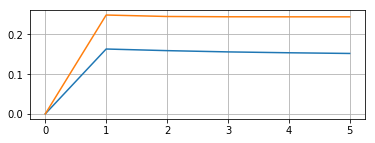

In [37]:
plt.figure(figsize=(6,2))
plt.plot(losses_train)
plt.plot(losses_test)
plt.grid()
plt.show()

## Save trained block

In [166]:
torch.save(model_mask.model6_1.state_dict(), './model/segm_block.pth')

## Test dataset

In [160]:
# load the best checkpoint
model_mask.load_state_dict(torch.load('./model/mask_0.186.pth'))

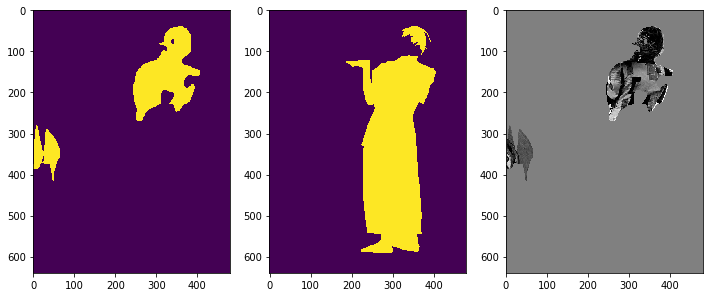

	IoU = 0.232, 	 CrossEntropy = 0.72 


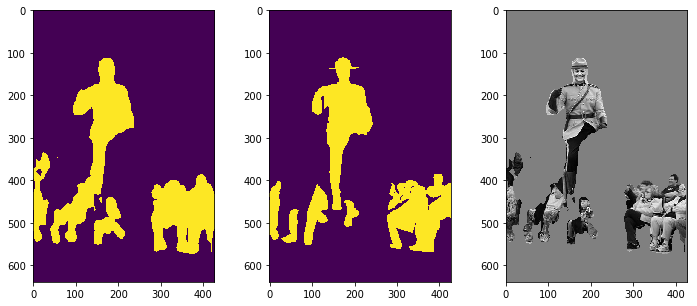

	IoU = 0.714, 	 CrossEntropy = 0.15 


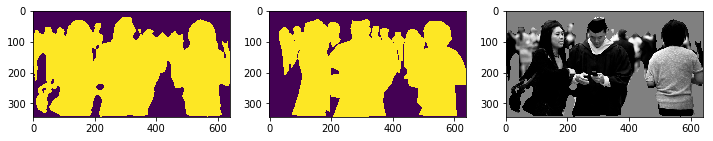

	IoU = 0.844, 	 CrossEntropy = 0.229 


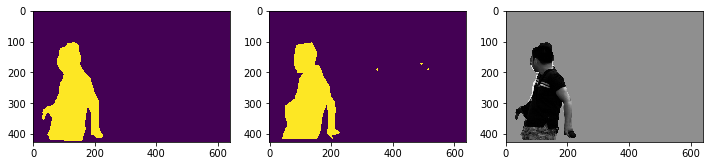

	IoU = 0.889, 	 CrossEntropy = 0.0441 


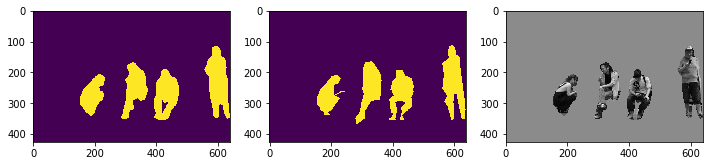

	IoU = 0.815, 	 CrossEntropy = 0.0596 


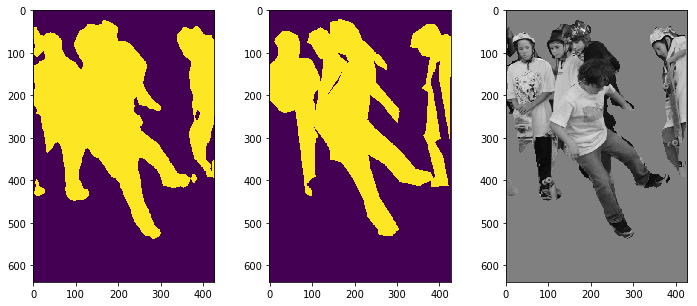

	IoU = 0.774, 	 CrossEntropy = 0.208 


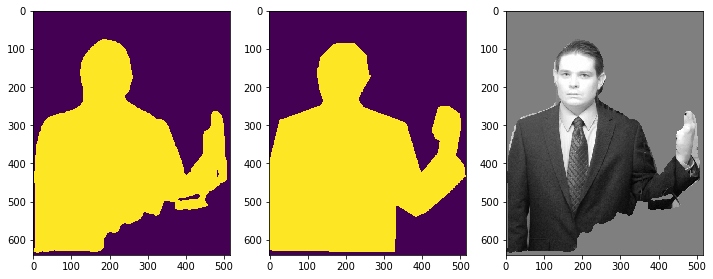

	IoU = 0.873, 	 CrossEntropy = 0.173 


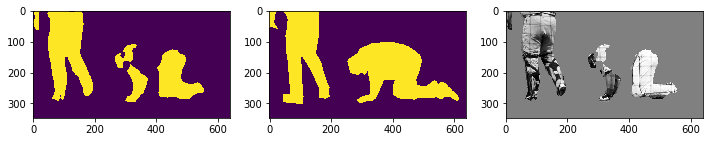

	IoU = 0.685, 	 CrossEntropy = 0.25 


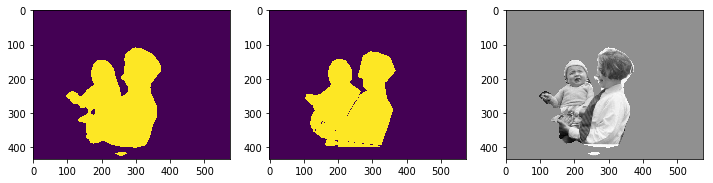

	IoU = 0.863, 	 CrossEntropy = 0.0862 


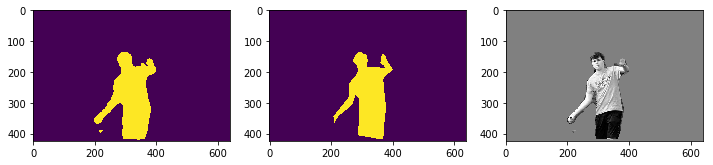

	IoU = 0.876, 	 CrossEntropy = 0.0843 

Total:
 	<IoU> = 0.757,	<CrossEntropy> = 0.201 


In [161]:
losses = []
IoUs = []
loss = nn.CrossEntropyLoss()
loss = loss.to(torch_device)

for i in range(10):
    
    sample = test_dataset[i]
    image = sample['image'].to(torch_device)
    mask = sample['mask'].to(torch_device)
    
    prediction, _ = model_mask(image)
    pred = nn.Upsample((mask.shape[0], mask.shape[1]), mode='bilinear', align_corners=True)(prediction) 
    image = nn.Upsample((mask.shape[0], mask.shape[1]), mode='bilinear', align_corners=True)(image)
    image = image[0][2].cpu().data.numpy()
    
    loss_batch = loss(pred, mask[None])
    losses.append(loss_batch.item())
 
    pred = nn.Softmax(dim=1)(pred)[0,1].cpu().data.numpy() > 0.5
    mask = mask.cpu().data.numpy().astype(bool)

    IoU = (mask&pred).sum() / (mask + pred).astype(bool).sum()
    IoUs.append(IoU)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)  
    #pred = gaussian_filter(pred, sigma=1)
    plt.imshow(pred)
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    
    plt.subplot(1, 3, 3)
    plt.imshow(image * (pred>0.5), cmap='gray')
    
    plt.show()
    print (('\tIoU = {0:.3}, \t CrossEntropy = {1:.3} ').format(IoU, losses[-1]))

print (('\nTotal:\n \t<IoU> = {0:.3},\t<CrossEntropy> = {1:.3} ').format(np.mean(IoUs), np.mean(losses)))

## Predict for a real image

In [162]:
img_path = './sample_image/3.jpg'
img = plt.imread(img_path)

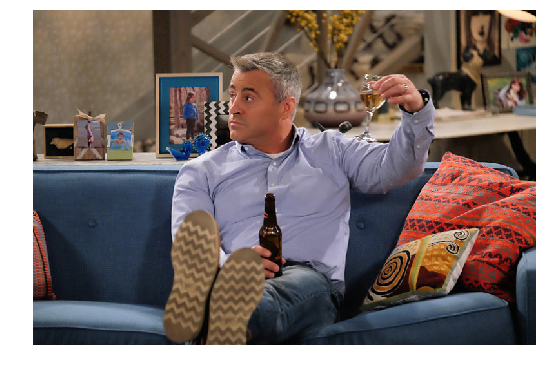

In [163]:
plt.figure(figsize=(9,9))
plt.imshow(img)
plt.axis('off')
plt.show()

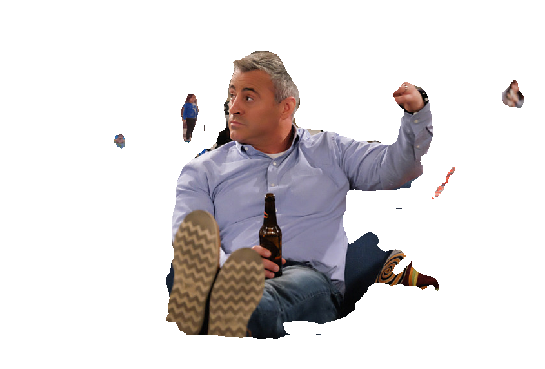

In [164]:

feed = prepare_image(img_path).to(torch_device)

prediction, _ = model_mask(feed)
prediction = nn.Upsample((img.shape[0], img.shape[1]), mode='bilinear', align_corners=True)(prediction)      
pred = nn.Softmax(dim=1)(prediction)[0,1].cpu().data.numpy()

alpha_pred = ((pred[:,:,None]>0.5)*255).astype(np.uint8)
plt.figure(figsize=(9,9))
plt.imshow(np.dstack([img, alpha_pred]))
plt.axis('off')
plt.show()

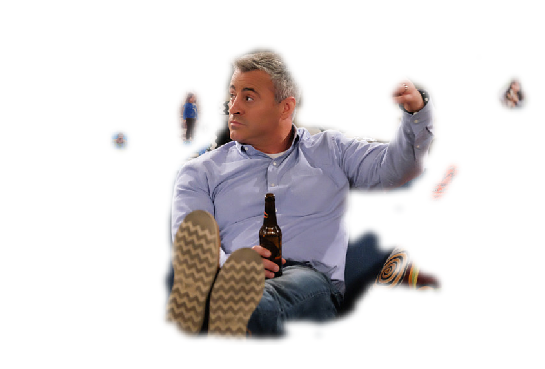

In [165]:
alpha_pred = ((pred[:,:,None]>0.5)*255).astype(np.uint8)
alpha_pred = gaussian_filter(alpha_pred, sigma=5)
plt.figure(figsize=(9,9))
plt.imshow(np.dstack([img, alpha_pred]))
plt.axis('off')
plt.show()